## EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







### Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from google.colab import drive 
import os
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from tqdm import tqdm

### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

### 1. Cargar base de datos

In [4]:
drive.mount('/content/drive')
path = '../content/drive/MyDrive/CEIA/TPS/DeepLearning'
os.listdir(path)

Mounted at /content/drive


['CNN_TP.ipynb',
 'test_label.pkl',
 'test.pkl',
 'val_label.pkl',
 'val.pkl',
 'train.pkl',
 'train_label.pkl',
 'CNN_implementacion.ipynb']

In [5]:
def cargarArchivo(ruta):
  file = open(ruta,"rb")
  datos = pickle.load(file)
  file.close()
  return datos

In [6]:
test_label = torch.from_numpy(cargarArchivo(path+"/test_label.pkl"))
test = torch.from_numpy(cargarArchivo(path+"/test.pkl")).type(torch.FloatTensor)
train_label = torch.from_numpy(cargarArchivo(path+"/train_label.pkl"))
train = torch.from_numpy(cargarArchivo(path+"/train.pkl")).type(torch.FloatTensor)
val_label = torch.from_numpy(cargarArchivo(path+"/val_label.pkl"))
val = torch.from_numpy(cargarArchivo(path+"/val.pkl")).type(torch.FloatTensor)

In [7]:
def normaliza(ds):
  # I can get what I want from below for-loop solution
  batches = ds.shape[0]
  for i in range(batches):
      ds[i] -= torch.min(ds[i])
      ds[i] /= torch.max(ds[i])

In [8]:
normaliza(train)
normaliza(test)
normaliza(val)

In [9]:
print("Shape de train_label:",train_label.shape)
print("Shape de train:",train.shape)
print("Shape de test_label:",test_label.shape)
print("Shape de test:",test.shape)
print("Shape de val_label:",val_label.shape)
print("Shape de val:",val.shape)

Shape de train_label: torch.Size([56000])
Shape de train: torch.Size([56000, 28, 28])
Shape de test_label: torch.Size([7000])
Shape de test: torch.Size([7000, 28, 28])
Shape de val_label: torch.Size([7000])
Shape de val: torch.Size([7000, 28, 28])


In [10]:
class CNNDataset(Dataset):

    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
        x = self.X_Train[idx]
        y = self.Y_Train[idx]

        return x, y

In [11]:
#paso a shape num_muestras, chanel, H, W
train = torch.unsqueeze(train,1)
test = torch.unsqueeze(test,1)
val = torch.unsqueeze(val,1)

In [12]:
#train_dataset = CNNDataset(torch.unsqueeze(train,1), train_label)
#test_dataset =  CNNDataset(torch.unsqueeze(test,1), test_label)
#validation_dataset = CNNDataset(torch.unsqueeze(val,1), val_label)
train_dataset = CNNDataset(train, train_label)
test_dataset =  CNNDataset(test, test_label)
validation_dataset = CNNDataset(val, val_label)

In [13]:
batch_size = 64
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True),
    'validation': torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
}

2. Ver que la base de datos esté OK

In [14]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


### 3. Pruebo ver una imagen

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


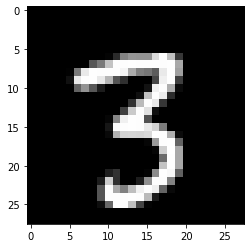

Label: 3


In [15]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

indice = 4
img = train_features[indice]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[indice].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[indice]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### 4.1 Construyo mi CNN base



In [16]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 128)
    self.conv2_out = None
    #self.conv3 = block(128, 128)
    #self.conv3_out = None
    #self.conv4 = block(128, 128)
    #self.conv4_out = None
    self.fc = torch.nn.Linear(128*7*7, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_capas=i
    self.tot_param=pytorch_total_params    

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    #x = self.conv3(x)
    #print("Tamaño salida conv3: ", x.shape)

    #x = self.conv4(x)
    #print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    #self.conv3_out = self.conv3(self.conv2_out)
    #self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.2 Construyo mi CNN version 2

In [17]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN2(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 4,k=5,pk=2,ps=2)
    self.conv1_out = None
    self.conv2 = block(4, 4,k=3,pk=2,ps=2)
    self.conv2_out = None
    self.conv3 = block(4, 4,k=3,pk=2,ps=2)
    self.conv3_out = None
    self.conv4 = block(4, 4,k=3,pk=2,ps=2)
    self.conv4_out = None
    self.conv5 = block(4, 4,k=3,pk=2,ps=2)
    self.conv5_out = None
    self.conv6 = block(4, 4,k=3,pk=2,ps=2)
    self.conv6_out = None
    self.fc = torch.nn.Linear(4*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_capas=i
    self.tot_param=pytorch_total_params    

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    y = self.conv6_out.view(self.conv6_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.3 Construyo mi CNN version 3

In [18]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN3(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 4,k=3,pk=2,ps=2)
    self.conv1_out = None
    self.conv2 = block(4, 4,k=3,pk=2,ps=2)
    self.conv2_out = None
    self.conv3 = block(4, 4,k=3,pk=2,ps=2)
    self.conv3_out = None
    self.conv4 = block(4, 4,k=3,pk=2,ps=2)
    self.conv4_out = None
    self.conv5 = block(4, 4,k=3,pk=2,ps=2)
    self.conv5_out = None
    self.conv6 = block(4, 4,k=3,pk=2,ps=2)
    self.conv6_out = None
    self.conv7 = block(4, 4,k=3,pk=2,ps=2)
    self.conv7_out = None
    self.fc = torch.nn.Linear(4*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_capas=i
    self.tot_param=pytorch_total_params    

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    y = self.conv6_out.view(self.conv6_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.4 Construyo mi CNN version 4

In [19]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN4(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 4,k=2,pk=2,ps=2)
    self.conv1_out = None
    self.conv2 = block(4, 4,k=2,pk=2,ps=2)
    self.conv2_out = None
    self.conv3 = block(4, 4,k=2,pk=2,ps=2)
    self.conv3_out = None
    self.conv4 = block(4, 4,k=2,pk=2,ps=2)
    self.conv4_out = None
    self.conv5 = block(4, 4,k=2,pk=2,ps=2)
    self.conv5_out = None
    self.conv6 = block(4, 4,k=2,pk=2,ps=2)
    self.conv6_out = None
    self.conv7 = block(4, 4,k=2,pk=2,ps=2)
    self.conv7_out = None
    self.conv8 = block(4, 4,k=2,pk=2,ps=2)
    self.conv8_out = None
    self.conv9 = block(4, 4,k=2,pk=2,ps=2)
    self.conv9_out = None        
    self.conv10 = block(4, 4,k=2,pk=2,ps=2)
    self.conv10_out = None
    self.conv11 = block(4, 4,k=2,pk=2,ps=2)
    self.conv11_out = None        
    self.fc = torch.nn.Linear(4*3*3, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    self.tot_capas=i
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_param=pytorch_total_params

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)
    x = self.conv7(x)
    print("Tamaño salida conv7: ", x.shape)
    x = self.conv8(x)
    print("Tamaño salida conv8: ", x.shape)
    x = self.conv9(x)
    print("Tamaño salida conv9: ", x.shape)
    x = self.conv10(x)
    print("Tamaño salida conv10: ", x.shape)
    x = self.conv11(x)
    print("Tamaño salida conv11: ", x.shape)                
    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    y = self.conv11_out.view(self.conv11_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.4 Construyo mi CNN version 5

In [68]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 8,k=3,pk=2,ps=1)
    self.conv1_out = None
    self.conv2 = block(8, 8,k=5,pk=2,ps=1)
    self.conv2_out = None
    self.conv3 = block(8, 8,k=3,pk=2,ps=2)
    self.conv3_out = None
    self.conv4 = block(8, 8,k=2,pk=2,ps=1)
    self.conv4_out = None
    self.conv5 = block(8, 8,k=3,pk=2,ps=2)
    self.conv5_out = None
    self.conv6 = block(8, 8,k=2,pk=2,ps=1)
    self.conv6_out = None
    self.conv7 = block(8, 8,k=2,pk=2,ps=2)
    self.conv7_out = None
    self.conv8 = block(8, 8,k=3,pk=2,ps=1)
    self.conv8_out = None
    self.conv9 = block(8, 8,k=2,pk=2,ps=2)
    self.conv9_out = None        
    self.conv10 = block(8,8,k=2,pk=2,ps=2)
    self.conv10_out = None
    self.conv11 = block(8, 8,k=2,pk=2,ps=2)
    self.conv11_out = None        
    self.fc = torch.nn.Linear(8*3*3, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    self.tot_capas=i
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_param=pytorch_total_params

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)
    x = self.conv7(x)
    print("Tamaño salida conv7: ", x.shape)
    x = self.conv8(x)
    print("Tamaño salida conv8: ", x.shape)
    x = self.conv9(x)
    print("Tamaño salida conv9: ", x.shape)
    x = self.conv10(x)
    print("Tamaño salida conv10: ", x.shape)
    x = self.conv11(x)
    print("Tamaño salida conv11: ", x.shape)                
    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    y = self.conv11_out.view(self.conv11_out.shape[0], -1)
    #y = self.conv6_out.view(self.conv6_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.4 Construyo mi CNN version 6

In [39]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),#Sigmoid(),#ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN6(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 4,k=2,pk=3,ps=2)
    self.conv1_out = None
    self.conv2 = block(4, 8,k=3,pk=2,ps=2)
    self.conv2_out = None
    self.conv3 = block(8, 8,k=4,pk=2,ps=2)
    self.conv3_out = None
    self.conv4 = block(8, 8,k=3,pk=2,ps=2)
    self.conv4_out = None
    self.conv5 = block(8, 8,k=2,pk=2,ps=1)
    self.conv5_out = None
    self.conv6 = block(8, 8,k=2,pk=2,ps=1)
    self.conv6_out = None
    self.conv7 = block(8, 8,k=3,pk=2,ps=1)
    self.conv7_out = None
    self.conv8 = block(8, 8,k=2,pk=2,ps=2)
    self.conv8_out = None
    self.conv9 = block(8, 4,k=2,pk=2,ps=1)
    self.conv9_out = None        
    self.conv10 = block(4,4,k=3,pk=2,ps=2)
    self.conv10_out = None
    self.conv11 = block(4, 4,k=2,pk=2,ps=2)
    self.conv11_out = None        
    self.fc = torch.nn.Linear(4*3*3, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    self.tot_capas=i
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_param=pytorch_total_params

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)
    x = self.conv7(x)
    print("Tamaño salida conv7: ", x.shape)
    x = self.conv8(x)
    print("Tamaño salida conv8: ", x.shape)
    x = self.conv9(x)
    print("Tamaño salida conv9: ", x.shape)
    x = self.conv10(x)
    print("Tamaño salida conv10: ", x.shape)
    x = self.conv11(x)
    print("Tamaño salida conv11: ", x.shape)                
    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    y = self.conv11_out.view(self.conv11_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### 4.4 Construyo mi CNN version 7

In [84]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN7(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 8,k=5,pk=2,ps=1)
    self.conv1_out = None
    self.conv2 = block(8, 8,k=3,pk=2,ps=1)
    self.conv2_out = None
    self.conv3 = block(8, 8,k=2,pk=2,ps=1)
    self.conv3_out = None
    self.conv4 = block(8, 8,k=3,pk=2,ps=1)
    self.conv4_out = None
    self.conv5 = block(8, 8,k=5,pk=2,ps=1)
    self.conv5_out = None
    self.conv6 = block(8, 8,k=2,pk=2,ps=2)
    self.conv6_out = None
    self.conv7 = block(8, 8,k=3,pk=2,ps=2)
    self.conv7_out = None
    self.conv8 = block(8, 8,k=2,pk=2,ps=2)
    self.conv8_out = None
    self.conv9 = block(8, 8,k=1,pk=2,ps=2)
    self.conv9_out = None        
    self.conv10 = block(8,8,k=1,pk=2,ps=1)
    self.conv10_out = None
    self.conv11 = block(8, 8,k=2,pk=2,ps=2)
    self.conv11_out = None        
    self.fc = torch.nn.Linear(200, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    self.tot_capas=i
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)
    self.tot_param=pytorch_total_params

  def validar_dim(self,tam):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    #tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)    
    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)
    x = self.conv7(x)
    print("Tamaño salida conv7: ", x.shape)
    x = self.conv8(x)
    print("Tamaño salida conv8: ", x.shape)
    x = self.conv9(x)
    print("Tamaño salida conv9: ", x.shape)
    x = self.conv10(x)
    print("Tamaño salida conv10: ", x.shape)
    x = self.conv11(x)
    print("Tamaño salida conv11: ", x.shape)                
    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    y = self.conv11_out.view(self.conv11_out.shape[0], -1)
    #y = self.conv6_out.view(self.conv6_out.shape[0], -1)
    y = self.fc(y)
    y = torch.nn.functional.softmax(y, dim=1)
    # x = self.sm(x)
    return y

### Armo mi funcion de fit

In [23]:
def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['validation'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}\n")
        

### Creo el modelo y valido dimensiones

In [93]:
#model = CNN()
model = CNN7()
model.validar_dim(28)
n_parameter= model.tot_param
n_layers= model.tot_capas
n_epochs = 1


Red creada
arquitectura:
CNN7(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, di

### Hago el entrenamiento del modelo

In [94]:
fit(model, dataloader,epochs=n_epochs)

val_loss 2.03283 val_acc 0.42543: 100%|██████████| 110/110 [00:00<00:00, 149.87it/s]


Epoch 1/1 loss 2.26418 val_loss 2.03283 acc 0.15329 val_acc 0.42543



### Calculo el score en test

In [95]:
model.eval()

val_acc = []
for x,y in dataloader['test']:
  longitud = len(y)
  y_hat = model(x.to(device))  
  acc = (y.to(device) == torch.argmax(y_hat, dim=1)).sum().item() / longitud
  val_acc.append(acc)

test_acc = np.mean(val_acc)
test_acc

0.4297348484848485

### score final obtenido

In [96]:
score=(1/np.log10(n_parameter))*(10/n_epochs)*test_acc*n_layers
print("Score final: ",score, "con n_parameter= ",n_parameter,", ",n_layers," layers,",n_epochs," epochs (acc=",test_acc,")")

Score final:  13.46040582583556 con n_parameter=  6778 ,  12  layers, 1  epochs (acc= 0.4297348484848485 )


### Resumen de resultados con los modelos

#### Para modelo base

* Score final:  0.7644789759231583 con n_parameter= 137226, 2 layers, 5 epochs (acc = 0.9812973484848484)
* Score final 3.403603291320133 con n_parameter= 137226, 2 layers, 1 epochs (acc = 0.8742897727272727)
* Score final: 1.886313256524483 con n_parameter= 137226, 2 layers, 2 epochs (acc = 0.9690814393939393)

#### Para modelo 2

* Score final:  3.7760370099968528 con n_parameter=  3262 ,  12  layers, 1  epochs (acc= 0.11055871212121213 )
* Score final:  5.461103632873392 con n_parameter=  3262 ,  12  layers, 3  epochs (acc= 0.4796875 )
* Score final:  5.274808359403741 con n_parameter=  3262 ,  12  layers, 5  epochs (acc= 0.7722064393939394 )

#### Para modelo 3

* Score final 4.15379885045299 con n_parameter= 1098, 8 layers, 3 epochs (acc = 0.47362689393939394)

#### Para modelo 4

* Score final:  3.9518237990429035 con n_parameter=  1070 ,  12  layers, 1  epochs (acc= 0.09976325757575757 )
* Score final:  1.4598178406526152 con n_parameter=  1070 ,  12  layers, 3  epochs (acc= 0.11055871212121213 )
* Score final:  0.8758907043915691 con n_parameter=  1070 ,  12  layers, 5  epochs (acc= 0.11055871212121213 )

#### Para modelo 5

* Score final:  7.211131309779322 con n_parameter=  5754 ,  12  layers, 1  epochs (acc= 0.2259469696969697 )
* Score final:  7.82389613503404 con n_parameter=  5754 ,  12  layers, 2  epochs (acc= 0.4902935606060606 )
* Score final:  5.936237949549406 con n_parameter=  5754 ,  12  layers, 3  epochs (acc= 0.5580018939393939 )


#### Para modelo 6

* Score final:  3.680307910618348 con n_parameter=  4026 ,  12  layers, 1  epochs (acc= 0.11055871212121213 )
* Score final:  6.072902089769805 con n_parameter=  4026 ,  12  layers, 2  epochs (acc= 0.36486742424242424 )
* Score final:  6.311425971485827 con n_parameter=  4026 ,  12  layers, 3  epochs (acc= 0.5687973484848485 )


#### Para modelo 7

* Score final:  13.46040582583556 con n_parameter=  6778 ,  12  layers, 1  epochs (acc= 0.4297348484848485 )
* Score final:  7.660092121026957 con n_parameter=  6778 ,  12  layers, 2  epochs (acc= 0.4891098484848485 )
* Score final:  6.358444973259033 con n_parameter=  6778 ,  12  layers, 3  epochs (acc= 0.6089962121212121 )

### Mejor resultado

El mejor score obtenido fue: 13.46040582583556
Con modelo 7
n_parameter: 677812
layers: 12
epochs: 1
acc: 0.4297348484848485 